In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 决策树构造

## 计算信息熵

In [4]:
from math import log
def calcShannonENT(dataset):
    '''
    计算信息熵
    '''
    numEntries = len(dataset)
    labelCounts = {}
    for featVec in dataset:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] =0
        labelCounts[currentLabel]+=1
    
    shannonEnt =0.0
    for key in labelCounts:
        prob = labelCounts[key] / numEntries
        shannonEnt -=prob * log(prob,2)
    return shannonEnt

In [60]:
def createDataSet():
    dataSet = [[1,1,'yes'],
              [1,1,'yes'],
              [0,1,'no'],
              [0,1,'no'],
              [1,0,'no']]
    labels = ['no surfacing','flippers']
    return dataSet,labels

In [61]:
mydata,_ = createDataSet()

In [62]:
mydata

[[1, 1, 'yes'], [1, 1, 'yes'], [0, 1, 'no'], [0, 1, 'no'], [1, 0, 'no']]

In [63]:
calcShannonENT(mydata)

0.9709505944546686

In [64]:
#混合信息越多熵越高
mydata[0][-1] = 'maybe'

In [65]:
calcShannonENT(mydata)

1.3709505944546687

## 按指定特征划分数据集

In [66]:
def splitDataSet(dataset,axis,value):
    '''
    返回指定特征划分数据集
    '''
    retDataSet = [] 
    for featVect in dataset:
        if(featVect[axis] == value):
            reducedFeatVect = featVect[:axis]
            reducedFeatVect.extend(featVect[axis+1:])
            retDataSet.append(reducedFeatVect)
    return retDataSet

In [67]:
mydata

[[1, 1, 'maybe'], [1, 1, 'yes'], [0, 1, 'no'], [0, 1, 'no'], [1, 0, 'no']]

In [68]:
mydata = splitDataSet(mydata,0,1)

In [69]:
mydata

[[1, 'maybe'], [1, 'yes'], [0, 'no']]

## 选择最好的数据集划分方式

In [70]:
def chooseBeastFeatureToSplit(dataSet):
    dimFeature = len(dataSet[0])-1
    baseEntropy = calcShannonENT(dataSet)
    bestinfoGain = 0.0    #信息增益 
    bestFeature = -1
    for dim in range(dimFeature):
        featlist = set([example[dim] for example in dataSet])
        newEntropy = 0.0
        for value in featlist:
            subdataset  = splitDataSet(dataSet,dim,value)
            prob = len(subdataset) / len(dataSet) 
            newEntropy+= prob * calcShannonENT(subdataset)
        infoGain = baseEntropy - newEntropy
        if(infoGain > bestinfoGain):
            bestinfoGain = infoGain
            bestFeature = dim
    return bestFeature

In [72]:
mydata,_  = createDataSet()
chooseBeastFeatureToSplit(mydata)

0

## 递归构建决策树

In [48]:
def majorityCnt(classList):
    '''
    返回出现次数最多的分类名称
    '''
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0 
        classCount[vote]+=1
    sortedClassCount = sorted(classCount.items(),key = lambda x:x[1],reverse=True)
    return sortedClassCount[0][0]

In [75]:
def createTree(dataset,labels):
    #类别完全相同，停止划分
    classList = [example[-1] for example in dataset]
    if len(set(classList)) == 1:
        return classList[0]
    #遍历完所有特征时，即splitdata已经划分完所有特征，只剩下label了
    #返回出现次数最多的类别
    if(len(dataset[0])==1):
        return majorityCnt(classList)
    ############以上是中止条件######################
    
    bestFeat = chooseBeastFeatureToSplit(dataset)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataset]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]  #复制，不改变原labels内容
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataset,bestFeat,value),
                                                 subLabels)
    return myTree

In [76]:
mydata,labels = createDataSet()
mytree = createTree(mydata,labels)
mytree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## matplotlib 绘制树形图

In [77]:
import matplotlib.pyplot as plt

In [78]:
decisionNode = dict(boxstyle='sawtooth',fc='0.8')
leafNode = dict(boxstyle='round4',fc='0.8')
arrow_args = dict(arrowstyle='<-')

def plotNode(nodeTxt,centerPt,parentPt,nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction', xytext=centerPt, 
                            textcoords='axes fraction', va="center", ha="center", bbox=nodeType, 
                            arrowprops=arrow_args)
def createPlot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    # ticks for demo puropses
    createPlot.ax1 = plt.subplot(111, frameon=False)
    plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
    plt.show()

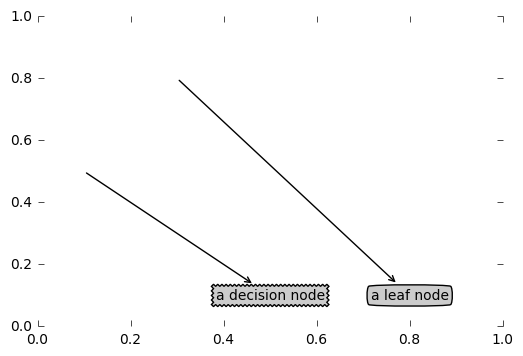

In [79]:
createPlot()

In [99]:
def getNumLeafs(mytree):
    '''
    获取叶节点数量
    '''
    numleafs = 0 
    #secondDict = mytree[list(mytree.keys())[0]]
    for key,value in mytree.items():
        if type(value) ==dict:
            numleafs +=getNumLeafs(value)
        else:
            numleafs +=1
    return numleafs

In [100]:
def getTreeDepth(mytree):
    maxdepth = 0 
    thisdepth = 0
    #secondDict = mytree[list(mytree.keys())[0]]
    for key ,value in mytree.items():
        if(type(value) == dict):
            thisdepth +=getTreeDepth(value)
        else:
            thisdepth = 1
        maxdepth = thisdepth if thisdepth>maxdepth else maxdepth
    return maxdepth

In [101]:
# 测试数据集
def retrieveTree(i):
    listOfTrees = [
        {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
        {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
    ]
    return listOfTrees[i]

In [103]:
mytree = retrieveTree(0)
print(mytree)
print(getNumLeafs(mytree))
print(getTreeDepth(mytree))

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
3
2
